<a href="https://colab.research.google.com/github/savtri/structDyn/blob/master/FreeDampedVibrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Χρήσιμες Βιβλιοθήκες
#Symbolic evaluations
import sympy as symp
from sympy.plotting import plot

#Standard Plotting
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as lines
import matplotlib.patches as patches

#Common controls
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, FloatSlider, Layout

#Numerics and plotting
import numpy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Math, Markdown, display

In [2]:
from google.colab import drive
drive.mount("/Collab Notebooks/StructuralDynamics", force_remount=True)

ValueError: ignored

# **2. Ελεύθερες ταλαντώσεις μονοβάθμιου ταλαντωτή με απόσβεση**

Στόχος της ενότητας αυτής είναι η συνοπτική παρουσίαση των αρχών που διέπουν τη δυναμική απόκριση ενός μονοβάθμιου ταλαντωτή υπό συνθήκες ελεύθερης ταλάντωσης με απόσβεση και  

*   H επίδραση της απόσβεσης στην απόκριση του ταλαντωτή
*   Η απώλεια ενέργειας λόγω απόσβεσης
*   Η ένοια της γωνιακή συχνότητας και ιδιοπεριόδου σε αποσβενόμενες     ταλαντώσεις

μέσα από παραδείγματα.

Το φύλλο αυτό στόχο έχει να λειτουργήσει υποβοηθητικά και όχι να αντικαταστήσει τη βιβλιογραφία σας και τις προσωπικές σας σημειώσεις. 

In [ ]:
#@title Χρήσιμες Συναρτήσεις (παίξε με δική σου ευθύνη)
#@hidden_cell

def find_nearest(array, value):
    array = sp.asarray(array)
    idx = (sp.abs(array - value)).argmin()
    return idx

def Get_Aspect(ax):
    left, right = ax.get_xlim()  # return the current xlim
    bot, top = ax.get_ylim()  # return the current xlim
    factor = fig.get_figwidth()*(1.2*top-1.2*bot)/fig.get_figheight()/(right-left)
    return factor  

def printmd(string):
    display(Markdown(string))

#Χρήσιμα συνάρτηση για "όμορφα" διαγράμματα
def plotFunc(ax, x, y, xmax=None, ymax=None, clr =None, alabel=None,\
             lstyle =None, amrk =None, amrkd=None, xlabel=None, ylabel=None, \
             ax_fs=None, grid=None,lwidth=None, setmnrgrid=False,setmjrgrid=False,\
             gridlstyle=None,mnrgridclr='lightgray',mjrgridclr='lightgray'):
    
    if xmax is not None:
        ax.set_xlim(xmax[0], xmax[1])
    if ymax is not None:
        ax.set_ylim(ymax[0], ymax[1])  

    if setmnrgrid == True:
        ax.grid(which='minor', )
        ax.grid(which='minor',alpha=0.5,color=mnrgridclr, \
                linestyle=gridlstyle, linewidth=1)        

    if setmjrgrid == True:        
        ax.grid(which='major',alpha=0.8,color=mjrgridclr, \
                linestyle=gridlstyle, linewidth=2)        
       
    ax.plot(x,y,clr, linewidth=lwidth, linestyle=lstyle,marker=amrk,markevery=amrkd, label=alabel)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=ax_fs)        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=ax_fs)
        

    if ax_fs is not None:
        ax.tick_params(axis='x', labelsize=ax_fs)
        ax.tick_params(axis='y', labelsize=ax_fs)

    if grid is not None:   
        ax.grid(grid)
    plt.gcf().canvas.flush_events()
    #ax.locator_params(axis='x', nbins=5)

#H λύση του προβλήματος της ελεύθερης ταλάντωσης μονοβάθμιου με απόσβεση    
def UndampedFree(u0,v0, M=1, K=4*sp.pi**2, tspan=1):
    omega=sp.sqrt(K/M)
    uS=  (v0/omega*symp.sin(omega*t)+u0*symp.cos(omega*t))
    vS=symp.diff(uS,t)
    aS=symp.diff(vS,t)    
    theta=sp.arctan(v0/omega/u0)
        
    u = symp.lambdify(t, uS,"numpy")
    v = symp.lambdify(t, vS,"numpy")
    a=  symp.lambdify(t,aS,"numpy")

    # Χρονικό διάστημα ταλάντωσης
    tt = sp.arange(0, tspan, 0.01)
    Fel=K*u(tt)
    Fin=M*a(tt)
    
    return tt, u, v,a, Fel, Fin,  

def DampedFree(u0,v0, M=1, K=4*sp.pi**2, C=1, tspan=1):
    omega=float(sp.sqrt(K/M)) #Γωνιακή συχνότητα ταλαντωτή
    ksi=C/(2*M*omega)         #Συντελεστής απόσβεσης
    #
    omegaD=omega*sp.sqrt(1-ksi**2)
    #
    T=float(2*sp.pi/omega)    #Ιδιοπερίοδος ταλαντωτή    
    #Πλάτος ταλάντωσης
    A=v0+u0*ksi*omega/omegaD
    B=u0
    rho=A**2+B**2
    rho=sp.sqrt(rho)
    #Φάση
    theta=sp.arctan(A/B)

    uS=  rho*symp.exp(-ksi*omega*t)*symp.cos(omegaD*t-theta)   #Λύση της εξίσωσης κίνησης 
    vS=symp.diff(uS,t)                                     #Παραγώγισε μία φορά για να πάρεις την ταχύτητα
    aS=symp.diff(vS,t)                                     #Παραγώγισε άλλη μία φορά για να πάρεις την επιτάχυνση
    
    tn = sp.arange(0, tspan, 0.01)

    u = symp.lambdify(t, uS,"numpy")
    v = symp.lambdify(t, vS,"numpy")
    a=  symp.lambdify(t,aS,"numpy")
            

    # Χρονικό διάστημα ταλάντωσης
    tt = sp.arange(0, tspan, 0.01)
    Fel=K*u(tt)
    Fin=M*a(tt)
    FD= C*v(tt)
    
    return tt, u, v,a, Fel, Fin, FD,    

#Xρήσιμη συνάρτηση για ομαδοποιημένα γραφήματα
def GetUFreePlots(M=1, K=4*sp.pi**2, C=1): 

    tt, u, v, a, Fel, Fin, FD=DampedFree(u0,v0,  M, K,C ) 
    tmp, uref, vref,aref, Fel_ref, Fin_ref, FD_ref=DampedFree(u0,v0 ) 

    #Plot Limits
    umax=max(sp.max(abs(u(tt))),sp.max(abs(uref(tt))))
    vmax=max(sp.max(abs(v(tt))),sp.max(abs(vref(tt))))  
    amax=max(sp.max(abs(a(tt))),sp.max(abs(aref(tt))))        
    Fin_max=max(M*sp.max(abs(a(tt))),1*sp.max(abs(aref(tt))))
    Fel_max=max(K*sp.max(abs(u(tt))),4*sp.pi**2*sp.max(abs(uref(tt))))
    FD_max=max(C*sp.max(abs(v(tt))),1*sp.max(abs(vref(tt))))

    fig=plt.figure(figsize=(15,8))    
    #Elastic force plot
    au=plt.subplot(2,3,1)    
    plotFunc(au,u(tt), Fel,[-umax, umax],[-Fel_max, Fel_max] ,'b',None,'dashed','s', 5,'Μετατόπιση $u$ [m]','Ελαστική Αντίδραση $F_R$ [kN]', 15,'on')    
    #Plot reference solution    
    plotFunc(au,uref(tt),Fel_ref,clr='r')
    #Inertia force plot
    aI=plt.subplot(2,3,2)    
    astring='$M=$ ' + str(sp.round(M,2)) + ' tn, $K$= ' + str(sp.round(K,2))   
    #plt.plot(u(tt),Fin,'b',label=astring,  linestyle='dashed',marker='s',markevery=5)
    plotFunc(aI,u(tt),Fin,[-umax, umax],[-Fin_max, Fin_max],'b',astring,'dashed','s',5,'Μετατόπιση $u$ [m]','Δύναμη Αδράνειας $F_Ι$ [kN]',15,'on')
    #Plot reference solution    
    plotFunc(aI,uref(tt),Fin_ref,alabel='$M=1.0$ tn, $K=4\pi^2$',clr='r')
    #Damping force plot
    aD=plt.subplot(2,3,3)            
    plotFunc(aD,u(tt),FD,[-umax, umax],[-FD_max, FD_max],'b',astring,'dashed','s',5,'Μετατόπιση $u$ [m]','Δύναμη Aπόσβεσης $F_D$ [kN]',15,'on')
    #Plot reference solution    
    plotFunc(aD,uref(tt),FD_ref,alabel='$M=1.0$ tn, $K=4\pi^2$',clr='r')
    plt.legend(fontsize=16,loc='upper left',frameon=False,bbox_to_anchor=(1.05, 1))    
    
    plt.legend(fontsize=16,loc='upper left',frameon=False,bbox_to_anchor=(1.05, 1))
    #Displacement Time history
    aut=plt.subplot(2,3,4)    
    plotFunc(aut,tt,u(tt),[0, T],[-umax, umax],'b',None,'dashed','s',5,'Χρόνος $t$ [sec]','Μετατόπιση $u$ [m]',15,'on')
    #Plot reference solution  
    plotFunc(aut,tt,uref(tt),clr='r')     
    #Acceleration Time History
    aat=plt.subplot(2,3,5)  
    plotFunc(aat,tt,a(tt),[0, T],[-amax, amax],'b',None,'dashed','s',5,'Χρόνος $t$ [sec]','Eπιτάχυνση $\ddot{u}$ [m/s$^2$]',15,'on')
    tmp=sp.max(aref(tt))    
    amax=max(tmp,amax)
    #Plot reference solution  
    plotFunc(aat,tt,aref(tt), ymax=[-amax, amax],clr='r') 
    fig.subplots_adjust(left=None,right=None, bottom=0.125, top=0.9, wspace= 0.5, hspace=0.5)
    plt.gcf().canvas.flush_events()
    return fig, au, aI, aut, aat, aD,     

#Xρήσιμη συνάρτηση για animation
def AnimateUDF(M=1, K=4*sp.pi**2, C=1):     
    omega=sp.sqrt(float(K)/M)
    T=2*sp.pi/omega
    omega_ref=sp.sqrt(float(K)/1)
    fig, au, aI, aut, aat,aD=GetUFreePlots(M,K,C  )
    #Animation    
    axNim=fig.add_subplot(2,3,6, frameon=False)        
    axNim.axis('off')    
    line1=lines.Line2D( [],[],zorder=1)
    line2=lines.Line2D( [],[],ls='--',zorder=1)
    line3=lines.Line2D( [],[],ls='--',zorder=1)
    axNim.add_line(line1)
    axNim.add_line(line2)
    axNim.add_line(line3)

    apatch=[None] * 6
    apatch[0] = patches.Circle((0.5, -0.5), 0.1, fc='m',zorder=2)
    factor=Get_Aspect(au)
    apatch[1]=patches.Ellipse((0.0, 0.0), .04, .04*factor,fc='m',zorder=2)
    factor=Get_Aspect(aI)
    apatch[2]=patches.Ellipse((0.0, 0.0), .04, .04*factor,fc='m',zorder=2)
    factor=Get_Aspect(aut)
    apatch[3]=patches.Ellipse((0.0, 0.0), .2, .2*factor,fc='m',zorder=2)
    factor=Get_Aspect(aat)
    apatch[4]=patches.Ellipse((0.0, 0.0), 0.2, 0.2*factor,fc='m',zorder=2)
    factor=Get_Aspect(aD)
    apatch[5]=patches.Ellipse((0.0, 0.0),  0.05, 0.05*factor,fc='m',zorder=2)    
    
    axNim.add_patch(apatch[0])
    au.add_patch(apatch[1])
    aI.add_patch(apatch[2])
    aut.add_patch(apatch[3])
    aat.add_patch(apatch[4])
    aD.add_patch(apatch[5])

    plt.gcf().canvas.flush_events()
    
    
    def init():
        line1.set_data([], [])
        line2.set_data([0.2, 0.2], [0, 1])
        line3.set_data([0.8, 0.8], [0, 1])
        axNim.add_patch(apatch[0])
        axNim.add_line(line1)
        axNim.add_line(line2)
        axNim.add_line(line3)
        au.add_patch(apatch[1])
        aI.add_patch(apatch[2])
        aut.add_patch(apatch[3])
        aat.add_patch(apatch[4])
        aD.add_patch(apatch[5])
        axNim.annotate('$u$=-0.1', xy=(0.2, 0.9), xytext=(0.2, 1),fontsize=15)
        axNim.annotate('$A^{\prime}$', xy=(2, 7), xytext=(0.2, 0.7),fontsize=15)
        axNim.annotate('$u$=0.1', xy=(0.2, 0.9), xytext=(0.8, 1),fontsize=15)
        axNim.annotate('$A$', xy=(0.8, 0.7), xytext=(8, 7),fontsize=15)
        aString='T= ' + str(round(T,1)) + ' sec'
        axNim.annotate(aString, xy=(0.3, 0.9), xytext=(0.3, 0.9),fontsize=15)        
        return  apatch

    def animate(i,omega_f, M, K):
        tt, u, v,a, Fel, Fin, FD,=DampedFree(u0,v0, M, K)
        
        x = 0.5+3*u(i)
        y = 0.5 
        line1.set_data([0.5,x],[0,y])        
        apatch[0].center = (x, y)                     
        apatch[1].center = (u(i), Fel[find_nearest( tt, i )]) 
                       
        apatch[2].center = (u(i), Fin[find_nearest( tt, i )])                
        apatch[3].center = (i, u(i))                
        apatch[4].center = (i, a(i))                        
        apatch[5].center = (u(i), FD[find_nearest( tt, i )])                
        return apatch

    #draw for 1 sec
    time=1;
    frames=sp.linspace(0, time, 20)    
    interval=time/len(frames)*1000    
    
    anim4 = animation.FuncAnimation(fig, animate, 
                                init_func=init, 
                                frames=frames, fargs=(omega,M, K,), 
                                interval=interval,
                                blit=True, repeat=False, cache_frame_data=True)
    plt.close()     
    return anim4         

def OmegaTimeHistories(M=1, omega=1, ksi=0, tspan=4): 
    #    
    
    K=M*omega**2
    C=ksi*(2*M*omega)
    #
    tt, u, v, a,Fel, Fin, FD =DampedFree( u0,v0,  M, K, C, tspan=tspan) 
    tmp, uref, vref,aref, Fel_ref, Fin_ref, FD=DampedFree(u0,v0,C=C, tspan=tspan )
    #
    tt, UDu, UDv, UDa,UDFel, UDFin, =UndampedFree( u0,v0,  M, K,  tspan)     
    #Plot_Limits
    umax=max(sp.max(abs(u(tt))),sp.max(abs(uref(tt))),sp.max(abs(UDu(tt))))    
    vmax=max(sp.max(abs(v(tt))),sp.max(abs(vref(tt))),sp.max(abs(UDv(tt))))
    amax=max(sp.max(abs(a(tt))),sp.max(abs(aref(tt))),sp.max(abs(UDa(tt))))
    
    plt.figure(figsize=(10,12))    
    #Displacement Time-History    
    au=plt.subplot(3,1,1)            
    astring='$\omega=$' + str(sp.round(omega,2)) + ' rad/sec'
    plotFunc(au, tt,u(tt),[0.0, tspan],[-umax, umax],'b' ,astring,\
             None,None,None, 'Χρόνος t [sec]','Μετατόπιση $u$ [m]',\
            ax_fs=15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(au,tt,uref(tt),[0.0, tspan],[-umax, umax],'r', \
             alabel='$\omega=2\pi$ rad/sec', lstyle=':')           
   
    #Plot solution at zero damping
    astring='$\omega=$' + str(sp.round(omega,2)) + ' rad/sec, C=0'
    plotFunc(au, tt,UDu(tt),[0.0, tspan],[-umax, umax],'g',\
             ax_fs=15,alabel=astring, amrk='s',amrkd=10,lstyle='--')    
                
    plt.legend(fontsize=16,loc='upper left',frameon=False,bbox_to_anchor=(1.05, 1))    

    #spacing = T/2 # This can be your user specified spacing. 
    #minor_ticks = sp.arange(0, 4, T/2)    
    #au.set_xticks(minor_ticks, minor=True)    
    
    #Velocity Time-History    
    av=plt.subplot(3,1,2)            
    plotFunc(av, tt,v(tt),[0.0, tspan],[-vmax, vmax],'b' ,astring,\
             None,None,None, 'Χρόνος t [sec]','Ταχύτητα $\dot{u}$ [m/s]',\
             ax_fs=15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(av,tt,vref(tt),[0.0, tspan],[-vmax, vmax],'r', \
             ax_fs=15,alabel='$\omega=2\pi$ rad/sec', lstyle=':')           
   
    #Plot solution at zero damping
    astring='$\omega=$' + str(sp.round(omega,2)) + ' rad/sec, C=0'
    plotFunc(av, tt,UDv(tt),[0.0, tspan],[-vmax, vmax],'g',\
             ax_fs=15,alabel=astring, amrk='s',amrkd=10,lstyle='--')  
    
    #Acceleration Time-History    
    aa=plt.subplot(3,1,3)            
    plotFunc(aa, tt,a(tt),[0.0, tspan],[-amax, amax],'b' ,astring,\
             None,None,None, 'Χρόνος t [sec]','Επιτάχυνση $\ddot{u}$ [m/s$^2$]',\
             ax_fs=15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(aa,tt,aref(tt),[0.0, tspan],[-amax, amax],'r', \
             ax_fs=15,alabel='$\omega=2\pi$ rad/sec', lstyle=':')           
   
    #Plot solution at zero damping
    astring='$\omega=$' + str(sp.round(omega,2)) + ' rad/sec, C=0'
    plotFunc(aa, tt,UDa(tt),[0.0, tspan],[-amax, amax],'g',\
             ax_fs=15,alabel=astring, amrk='s',amrkd=10,lstyle='--')  
    
def ksiTimeHistories(M=1, omega=1, ksi=0, tspan=4): 
    #        
    K=M*omega**2
    C=ksi*(2*M*omega)
    C_ref=0.05*(2*M*omega)
    #
    tt, u, v, a,Fel, Fin, FD =DampedFree( u0,v0,  M, K, C, tspan=tspan) 
    tmp, uref, vref,aref, Fel_ref, Fin_ref, FD=DampedFree(u0,v0,C=C_ref, tspan=tspan )
    #
    tt, UDu, UDv, UDa,UDFel, UDFin, =UndampedFree(  u0,v0,  M, K,  tspan)     
    #Plot_Limits
    umax=max(sp.max(abs(u(tt))),sp.max(abs(uref(tt))),sp.max(abs(UDu(tt))))    
    vmax=max(sp.max(abs(v(tt))),sp.max(abs(vref(tt))),sp.max(abs(UDv(tt))))
    amax=max(sp.max(abs(a(tt))),sp.max(abs(aref(tt))),sp.max(abs(UDa(tt))))
    
    plt.figure(figsize=(10,12))    
    #Displacement Time-History    
    au=plt.subplot(3,1,1)            
    astring = '$\\xi =$' + str(sp.round(100*ksi,2)) + ' $\%$'
    plotFunc(au, tt,u(tt),[0.0, tspan],[-umax, umax],'b' ,astring,\
             None,None,None, None,'Μετατόπιση $u$ [m]',\
             15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(au,tt,uref(tt),[0.0, tspan],[-umax, umax],'r', \
             alabel='$\\xi=5\%$', lstyle=':')           
   
    #Plot solution at zero damping
    astring='$\\xi=0$'
    plotFunc(au, tt,UDu(tt),[0.0, tspan],[-umax, umax],'g',\
             alabel=astring, amrk='s',amrkd=10,lstyle='--')    
                
    plt.legend(fontsize=16,loc='upper left',frameon=False,bbox_to_anchor=(1.05, 1))    

    #spacing = T/2 # This can be your user specified spacing. 
    #minor_ticks = sp.arange(0, 4, T/2)    
    #au.set_xticks(minor_ticks, minor=True)    
    
    #Velocity Time-History    
    av=plt.subplot(3,1,2)            
    plotFunc(av, tt,v(tt),[0.0, tspan],[-vmax, vmax],'b' ,astring,\
             None,None,None, None,'Ταχύτητα $\dot{u}$ [m/s]',\
             15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(av,tt,vref(tt),[0.0, tspan],[-vmax, vmax],'r', lstyle=':')           
   
    #Plot solution at zero damping    
    plotFunc(av, tt,UDv(tt),[0.0, tspan],[-vmax, vmax],'g',\
              amrk='s',amrkd=10,lstyle='--')  
    
    #Acceleration Time-History    
    aa=plt.subplot(3,1,3)            
    plotFunc(aa, tt,a(tt),[0.0, tspan],[-amax, amax],'b' ,astring,\
             None,None,None, 'Χρόνος t [sec]','Επιτάχυνση $\ddot{u}$ [m/s$^2$]',\
             15,lwidth=2, grid='on', setmjrgrid=True, gridlstyle=':')    
    
    #Plot reference solution    
    plotFunc(aa,tt,aref(tt),[0.0, tspan],[-amax, amax],'r', \
             lstyle=':')           
   
    #Plot solution at zero damping
    astring='$\omega=$' + str(sp.round(omega,2)) + ' rad/sec, C=0'
    plotFunc(aa, tt,UDa(tt),[0.0, tspan],[-amax, amax],'g',\
             amrk='s',amrkd=10,lstyle='--')         

In [ ]:
#@title Ορισμοί συμβόλων 
#Oι ορισμοί είναι απαραίτητοι για να πραγματοποιηθούν αναλυτικά οι παραγωγίσεις
t=symp.Symbol('t', positive=symp.true)
u=symp.Function('u')(t)
v=symp.Function('v')(t)
a=symp.Function('a')(t)


## **2.1 Θεωρία**
----




### 2.1.1 Εξίσωση κίνησης

Η εξίσωση κίνησης του ελεύθερου μονοβάθμιου ταλαντωτή με απόσβεση είναι

\begin{align}
m\ddot{u}+C\dot{u}+Ku=0 \tag{1}
\end{align}

όπου $m$ είναι η μάζα, $Κ$ η στιβαρρότητα, $C$ η σταθερά απόσβεσης, $u=u(t)$ η μετατόπιση και $\ddot{u}=\frac{d^2u}{dt^2}$ η επιτάχυνση του ταλαντωτή. 

**Παρατήρηση** Στην εξίσωση $(1)$, ο όρος της απόσβεσης υπονοεί πώς το σύστημα έχει ιξώδη χαρακτηριστικά. Υπενθυμίζεται πως τούτο είναι μια παραδοχή η οποία οδηγεί σε εύχρηστες αναλυτικές λύσεις. Προφανώς τα τυπικά υλικά μας (χάλυβας, σκυρόδεμα, γεωϋλικά εν γένει) απέχουν πολύ από την κατάσταση του ρευστού. 

Κατά τα γνωστά, η εξίσωση $(1)$ συνοδεύεται από το ακόλουθο σετ αρχικών συνθηκών
<br><br>
\begin{align}
&u(t=0)=u_0\\
&~\tag{ΣΣ}\\
&\dot{u}(t=0)= \left.\frac{du}{dt} \right|_{t = 0}=\dot{u}_0
\end{align}
<br><br>

οι οποίες όπως έχουμε δει "εμπλουτίζουν" το σύστημα με ένα αρχικό ποσό ενέργειας το οποίο και θέτει το σύστημα σε κίνηση. 

Η εξίσωση $({1})$ υπό τις συνοριακές συνθήκες $({ΣΣ})$ έχει αναλυτική λύση.Είδαμε στο μάθημα πως ανάλογα με τη σχέση που διέπει τις μηχανικές παραμέτρους του συστήματος, $Μ$, $C$ και $K$ η φύση της λύσης, δηλαδή της απόκρισης $u(t)$ διαφέρει σημαντικά. 

Χάρην της επανάληψης, είδαμε πως 

1. Όταν $c=2M\omega$ η απόκριση δεν είναι ταλάντωση και η κίνηση αποσβένειται σε πεπερασμένο χρόνο. Η τιμή αυτή της σταθεράς απόσβεσης ονομάζεται κρίσιμη απόσβεση $c_{cr}$.
2. Όταν $c>c_{cr}$, η απόκριση επίσης δεν είναι ταλάντωση και η κίνηση αποσβένειται σε πεπερασμένο χρόνο. Στην περίπτωση αυτή λέμε ότι έχουμε συστήματα με *υπερκρίσιμη απόσβεση*.
3. Μόνο όταν $c<c_{cr}$, η απόκριση είναι ταλάντωση της οποίας το πλάτος μειώνεται με την πάροδο του χρόνου, έως ότου το σύστημα καταλήξει σε κατάσταση ηρεμίας (ταχύτητα = 0). Στην περίπτωση αυτή λέμε ότι έχουμε συστήματα με *υποκρίσιμη απόσβεση*.

Η τελευταία περίπτωση είναι και η πλέον ενδιαφέρουσα για τα υλικά που μας ενδιαφέρουν. Είθισται να χαρακτηρίζουμε ένα σύστημα με τη βοήθεια του λεγόμενου *λόγου απόσβεσης* $\xi$ ο οποίος ορίζεται ως

\begin{equation}
\xi=\frac{c}{c_{cr}}=\frac{c}{2M\omega}
\end{equation}

Σύμφωνα με τα παραπάνω, όταν $\xi<1$ το σύστημα είναι υποκρίσιμο και η απόκριση του είναι ταλάντωση. Ενδεικτικά αναφέρουμε πως τα συνήθη υλικά ενδιαφέροντος πολιτικού μηχανικού έχουν λόγους απόσβεσης $1\%<\xi<7\%$, δηλαδή αρκετά μικρότερους της μονάδας. 

Στα υποκρίσιμα συστήματα, η λύση της εξίσωσης $(1)$ είναι

\begin{equation}
u(t)=\rho e^{-\xi \omega t} \cos(\omega_D t - \theta)
\end{equation}


όπου $\omega$ είναι η γωνιακή ιδιοσυχνότητα του ταλαντωτή, $\omega_D$ η αποσβενημένη ιδιοσυχνότητα

\begin{equation}
\omega_D= \omega \sqrt{1-\xi^2} \tag{5}
\end{equation}

ενώ, $\rho$ είναι το πλάτος της ταλάντωσης το οποίο εξαρτάται από τις αρχικές συνθήκες και την γωνιακή ιδιοσυχνότητα

\begin{equation}
\rho=\sqrt{\left(\frac{\dot{u}_0+u_0\xi\omega}{\omega_D}\right)^2+u_0^2}
\end{equation}

και $\theta$ η διαφορά φάσης της ταλάντωσης

\begin{equation}
\theta=Arctan\left(\frac{\dot{u}_0+u_0\xi\omega}{\omega_D u_0}\right).
\end{equation}

#### **Ερώτηση 1**

Για εξάσκηση, προσπαθήστε να εξάγετε την εξίσωση $(1)$ εφαρμόζοντας κατάλληλες σχέσεις ισορροπίας για το σύστημα. 

---

### 1.1.2 Ενέργεια

Ο ταλαντωτής μας, διακατέχεται από δύο και δύο μόνο είδη ενέργειας, τα οποία θα δούμε πώς σε κάθε χρονική στιγμή ανταγωνίζονται το ένα το άλλο. 

1. Κινητική ενέργεια που προκύπτει από τη δυνατότητα της μάζας να κινείται με μία ταχύτητα $\dot{u(t)}$

\begin{equation}
E_{kin}=\frac{1}{2}M\dot{u}(t)^2 \tag{6}
\end{equation}

2. Δυναμική ενέργεια η οποία προκύπτει από την **κατάσταση** του ταλαντωτή. Στη συγκεκριμένη περίπτωση η **κατάσταση** είναι η παραμόρφωσή του και επομένως η δυναμική του ενέργεια αντιστοιχεί στην ελαστική ενέργεια παραμόρφωσης

\begin{equation}
E_{pot}=\frac{1}{2}Ku(t)^2 \tag{7}
\end{equation}

H ολική ενέργεια του συστήματος σε κάθε χρονική στιγμή είναι το άθροισμα της κινητικής και της δυναμικής ενέργειας, δηλαδή

\begin{equation}
E_{tot}=\frac{1}{2}M\dot{u}(t)^2+\frac{1}{2}Ku(t)^2 \tag{8}
\end{equation}
<br><br>
Προφανώς, αφού η μετατόπιση και η ταχύτητα μεταβάλλονται στο χρόνο, η κινητική και η δυναμική ενέργεια θα μεταβάλλονται επίσης. Σημαίνει αυτό ότι και η ολική ενέργεια μεταβάλλεται? Η απάντηση είναι **ΟΧΙ**.
<br><br>
Σε ένα σύστημα χωρίς απόσβεση το οποίο αφήνεται να ταλαντωθεί μόνο του **(ελεύθερη ταλάντωση)**, η ολική ενέργειά του παραμένει σε κάθε χρονική στιγμή σταθερή και ίση με την αρχική ενέργεια που, με κάποιο τρόπο δόθηκε στο σύστημα. 
<br><br>
Επομένως, εφόσον η ολική ενέργεια παραμένει σταθερή, η κινητική και η δυναμική ενέργεια του συστήματος, σε τελική ανάλυση η ταχύτητα και η μετατόπιση, μάλλον θα ανταγωνίζονται η μία την άλλη. Όσο αυξάνεται η μετατόπιση θα μειώνεται η ταχύτητα και αντίστροφα! 

#### **Ερώτηση 2**

Ωραία η συζήτηση για την *αρχική ενέργεια* του συστήματος. Από που προκύπτει αυτή η ενέργεια όμως? 

(Αφού ξοδέψεις 2 λεπτά, πάτα το μικρό τρίγωνο στα δεξιά για να δεις την απάντηση)

---

Aπό τις αρχικές συνθήκες φυσικά! H αρχική μετατόπιση και η αρχική ταχύτητα **εμπλουτίζουν** το σύστημα με ενέργεια
<br><br>
\begin{equation}
E_{tot}=\frac{1}{2}M\dot{u}_0^2+\frac{1}{2}Ku_0^2 \tag{E1}
\end{equation}

Κατά την ελεύθερή του ταλάντωση, το σύστημα δε μπορεί να κάνει τίποτα άλλο από το να διατηρεί αυτή την ενέργεια σταθερή. Αυτό σημαίνει πως η ταχύτητα και η μετατόπιση του ταλαντωτή θα πρέπει να σχετίζονται με τέτοιο τρόπο ώστε η ολική ενέργεια του συστήματος να είναι πάντα ίση με το αποτέλεσμα της εξίσωσης $(E1)$.

Όσοι δεν πιστεύουν, μπορούν να αντικαταστάσουν τις εκφράσεις της μετατόπισης $(2)$ και της ταχύτητας $(3)$ στην $(8)$, να εφαρμόσουν λίγη τριγωνομετρία και να συγκρίνουν το αποτέλεσμα με την $(Ε1)$.


## **1.2 Εφαρμογές**
----

###Εφαρμογή 1.1 - Με ή χωρίς απόσβεση 

Ας θεωρήσουμε (ναι πάλι) την περίπτωση κατά την οποία απομακρύνουμε έναν ταλαντωτή μάζας $Μ=4\pi^2$ tn και στιβαρρότητας $K=1$ kN/m από τη θέση ισορροπίας του κατά $u_0=-0.1$m. Τον κρατάμε στη θέση αυτή και τη χρονική στιγμή $t=0$ τον αφήνουμε να ταλαντωθεί. <br><br>









Σύμφωνα με τη σχέση $(5)$ η γωνιακή συχνότητα του ταλαντωτή προκύπτει ίση με 

\begin{equation}
\omega=\sqrt{\frac{4\pi^2}{1}}=2\pi \text{ rad/sec}.
\end{equation}

Η ιδιοπερίοδος του ταλαντωτή είναι επομένως

\begin{equation}
T=\frac{2\pi}{\omega}=1 \text{ sec}
\end{equation}
<br><br>

In [ ]:
# Μηχανικές Ιδιότητες
M_ref=1.0 # Μ = Μάζα  
K_ref=4*sp.pi**2 # Κ= στιβαρότητα
C_ref=1          # C=σταθερά απόσβεσης

# Αρχικές Συνθήκες
u0=0.1 # u0 Aρχική μετατόπιση 
v0=10.0 # v0 aρχική ταχύτητα

**Παρατήρηση 1**. Οι σχέσεις $(1.1)$, $(1.2)$ και $(1.3)$ έχουν τα ίδια *ποιοτικά* χαρακτηριστικά. Η μεταβολή της μετατόπισης, της ταχύτητας και της επιτάχυνσης, αντίστοιχα, προκύπτει ως το γινόμενο ενός σταθερού όρου και ενός χρονικά μεταβαλλόμενου *τριγωνομετρικού* όρου. 

Ο τριγωνομετρικός όρος είναι προφανώς φραγμένος στο διάστημα $[-1,1]$. Επομένως, ο σταθερός όρος καθορίζει το εύρος μεταβολής (ή την μέγιστη και την ελάχιστη τιμή) του αντίστοιχου μεγέθους. Ο σταθερός όρος επομένως ονομάζεται *πλάτος ταλάντωσης* της μετατόπισης, της ταχύτητας και της επιτάχυνσης αντίστοιχα. 

Στο ακόλουθο κελί, παράγονται οι παραπάνω σχέσεις για περαιτέρω επεξεργασία. 

Η μεταβολή της μετατόπισης, της ταχύτητας και της επιτάχυνσης του ταλαντωτή στο χρόνο παρουσιάζονται αμέσως μετά. 




In [ ]:
omega=float(sp.sqrt(K_ref/M_ref)) #Γωνιακή συχνότητα ταλαντωτή
ksi=C_ref/(2*M_ref*omega)         #Συντελεστής απόσβεσης
omegaD=omega*sp.sqrt(1-ksi**2)
T=float(2*sp.pi/omega)    #Ιδιοπερίοδος ταλαντωτή
#Πλάτος ταλάντωσης
A=v0+u0*ksi*omega/omegaD
B=u0
rho=A**2+B**2
rho=sp.sqrt(rho)
#Φάση
theta=sp.arctan(A/B)

uS=  rho*symp.exp(-ksi*omega*t)*symp.cos(omegaD*t-theta)   #Λύση της εξίσωσης κίνησης 
vS=symp.diff(uS,t)                                     #Παραγώγισε μία φορά για να πάρεις την ταχύτητα
aS=symp.diff(vS,t)                                     #Παραγώγισε άλλη μία φορά για να πάρεις την επιτάχυνση

#Υπολόγισε τη λύση για 8 περιόδους 
nPeriods=8

tn = sp.arange(0, nPeriods*T, 0.01)

u = symp.lambdify(t, uS,"numpy")
v = symp.lambdify(t, vS,"numpy")
a=  symp.lambdify(t,aS,"numpy")

#Υπολόγισε επίσης τη λύση για 0 απόσβεση
ksi0=0
omegaD=omega*sp.sqrt(1-ksi0**2)
#Πλάτος ταλάντωσης
A=v0+u0*ksi0*omega/omegaD
B=u0
rho=A**2+B**2
rho=sp.sqrt(rho)
#Φάση
theta=sp.arctan(A/B)

uS_UD=  rho*symp.exp(-ksi0*omega*t)*symp.cos(omegaD*t-theta)   #Λύση της εξίσωσης κίνησης 
vS_UD=symp.diff(uS_UD,t)                                     #Παραγώγισε μία φορά για να πάρεις την ταχύτητα
aS_UD=symp.diff(vS_UD,t)                                     #Παραγώγισε άλλη μία φορά για να πάρεις την επιτάχυνση

uref = symp.lambdify(t, uS_UD,"numpy")
vref = symp.lambdify(t, vS_UD,"numpy")
aref=  symp.lambdify(t,aS_UD,"numpy")

display(v(0))
display(vref(0))


62.632593435333206

62.8318530717959

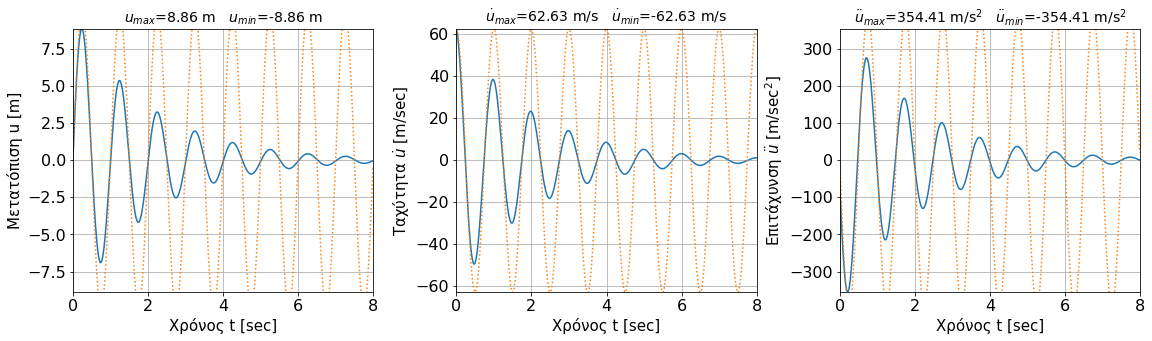

In [ ]:
#@title 
fig, au =  plt.subplots(1,3)
fig.set_size_inches(16,5)
# Plot the data
au[0].plot(tn,u(tn))
au[0].plot(tn,uref(tn),linestyle=':')
au[0].set_xlim(0.0, nPeriods*T)
umax=sp.amax(sp.abs(u(tn)))
au[0].set_ylim(-umax,umax)
au[0].set_xlabel('Χρόνος t [sec]', fontsize=15)
au[0].set_ylabel('Mετατόπιση u [m]', fontsize=15)
string1='$u_{max}$='+str(abs(round(umax,2))) +' m' 
string2='   $u_{min}$='+str(-abs(round(umax,2))) +' m'
string=string1+string2
au[0].title.set_text(string)

# Plot the data
au[1].plot(tn,v(tn))
au[1].plot(tn,vref(tn),linestyle=':')
au[1].set_xlim(0.0, float(nPeriods*T))
vmax=sp.amax(sp.abs(v(tn)))
au[1].set_ylim(-vmax,vmax)
au[1].set_xlabel('Χρόνος t [sec]', fontsize=15)
au[1].set_ylabel('Ταχύτητα $\dot{u}$ [m/sec]', fontsize=15)
string1='$\dot{u}_{max}$='+str(abs(round(vmax,2))) +' m/s' 
string2='   $\dot{u}_{min}$='+str(-abs(round(vmax,2))) +' m/s'
string=string1+string2
au[1].title.set_text(string)

# Plot the data
au[2].plot(tn, a(tn))
au[2].plot(tn,aref(tn),linestyle=':')
au[2].set_xlim(0.0, float(nPeriods*T))
amax=sp.amax(sp.abs(a(tn)))
au[2].set_ylim(-amax,amax)
au[2].set_xlabel('Χρόνος t [sec]', fontsize=15)
au[2].set_ylabel('Επιτάχυνση $\ddot{u}$ [m/sec$^2$]', fontsize=15)
string1='$\ddot{u}_{max}$='+str(abs(round(amax,2))) +' m/s$^2$' 
string2='   $\ddot{u}_{min}$='+str(-abs(round(amax,2))) +' m/s$^2$'
string=string1+string2
au[2].title.set_text(string)
fig.tight_layout(pad=2.0)
for ax in au:
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.title.set_fontsize(14)
    ax.grid()


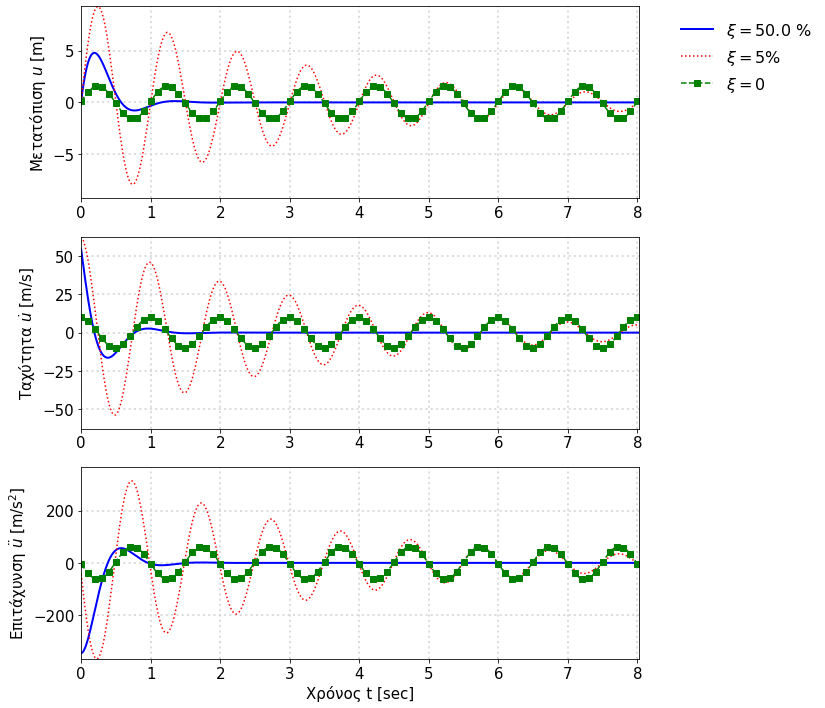

In [ ]:
omega=float(sp.sqrt(K_ref/M_ref)) #Γωνιακή συχνότητα ταλαντωτή
ksi=C_ref/(2*M_ref*omega)         #Συντελεστής απόσβεσης
omegaD=omega*sp.sqrt(1-ksi**2)
T=float(2*sp.pi/omegaD)    #Ιδιοπερίοδος ταλαντωτή

ksiB = widgets.FloatSlider(min=0.0, max=0.99, step=0.02, value=ksi, description='Λόγος Απόσβεσης', disabled=False, continuous_update=False)
ui = widgets.HBox([ksiB])

out = widgets.interactive_output(ksiTimeHistories, {'M': fixed(M_ref), 'omega':fixed(omega), 'ksi': ksiB,'tspan': fixed(8*T)})
display(ui, out)







#### **Ερώτηση 3**
Το πλάτος της μετατόπισης είναι ίσο με την αρχική μετατόπιση που επιβάλαμε στον ταλαντωτή, ούτε μικρότερη, ούτε μεγαλύτερη. Ισχύει δηλαδή

\begin{equation}
u_{max}=\left|u_0\right|
\end{equation}

Θα έπρεπε να το περιμένουμε? Αφού σκεφτείς για δύο λεπτά, πάτα το τριγωνάκι πάνω αριστερά για να δεις την απάντηση.

---

Φυσικά! θυμηθείτε τη συζήτηση στην ενότητα 1.1.2 για τη διατήρηση της ενέργειας. Εφόσον αρχικά μετακινήσαμε τον ταλαντωτή κατά $u_0$ και μετά τον αφήσαμε, η αρχική ολική ενέργεια που προσδώσαμε στο σύστημα ήταν 

\begin{equation}
E_{tot}=\frac{1}{2}Ku_0^2
\end{equation}

Αυτό που γνωρίζουμε εξορισμού για τη θέση μέγιστης μετατόπισης είναι πως στιγμιαία εκεί ο ταλαντωτής θα σταματήσει. Η ταχύτητα του θα είναι ίση με 0. Επομένως σε αυτή τη θέση, ας την πούμε $u_{max}$, η ολική ενέργεια θα είναι

\begin{equation}
E_{tot}=\frac{1}{2}K{u_max}^2
\end{equation}

Αρκεί να εξισώσουμε τις δύο σχέσεις για να προκύψει ότι η μέγιστη μετατόπιση καθ'όλη τη διάρκεια της ταλάντωσης θα είναι πάντα ίση με την αρχική. 

Αν ακόμα δεν πιστεύετε, τότε...https://www.youtube.com/watch?v=WfQwE168Jes
(Η συζήτηση αφορά το εκκρεμές αλλά θεωρώ ότι η αναλογία είναι προφανής. Παρακαλώ προσέξτε τη σημασία που δίνει στη συνθήκη μηδενικής αρχικής ταχύτητας (just release, do not launch).


### Eφαρμογή 1.2 Γιατί ταλαντώνεται?

Ας δούμε το διάγραμμα μεταβολής της μετατόπισης. Tη χρονική στιγμή $t=0$ εκρέπουμε τον ταλαντωτή από τη θέση ισορροπίας του κατά $u_0$ και επομένος αυτός βρίσκεται στη θέση $Α$ όπως σημειώνεται τόσο στο σχήμα όσο και στο διάγραμμα μεταβολής της μετατόπισης. 

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1mX11fsBVcXr8H0pSTM4COYOTcBMjNtwF' width="558" height="300"/>
<figcaption>Αρχική συνθήκη. Ο ταλαντωτής στη θέση Α και περιμένει να τον αφήσουμε</figcaption></center>
</figure>

Αφήνοντας τον ταλαντωτή ελεύθερο, αυτός θα *επιταχύνει* προς τα δεξιά, θα περάσει από τη θέση ισορροπίας $Ο$ και θα κινηθεί μέχρι την ακραία θέση $Α'$ η οποία όπως είδαμε θα απέχει $-u_0$ από τη θέση ισορροπίας $Ο$.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1qYzFvoxYwlrgE7WfflHfDSBLoZjiFdFu' width="558" height="300"/>
<figcaption>Ο ταλαντωτής έχει αφεθεί και καταλήγει στη θέση Γ έχοντας περάσει από τη θέση Β</figcaption></center>
</figure>

Σταματάει ο ταλαντωτής στη θέση $Α'$? Η εμπειρία και τα μαθηματικά (βλ. εξίσωση $(1.1)$ λένε όχι. Ο ταλαντωτής θα συνεχίσει να κινείται μεταξύ των θέσεων $Α$ και $Α'$ για πάντα. 

To *για πάντα* το αντιμετωπίσαμε στην Ενότητα 1.1.2, όπου και είδαμε ότι απουσία απόσβεσης η ενέργεια του συστήματος διατηρείται αναλλοίωτη και ίση με την ενέργεια που αρχικά προσδώσαμε στο σύστημα. 

Για του λόγου το αληθές στο ακόλουθο σχήμα παρουσιάζεται η μεταβολή της κινιτικής ενέργειας $Ε_{kin}$, της δυναμικής ενέργειας $E_{pot}$ και της συνολικής ενέργειασ $Ε_{tot}$. 


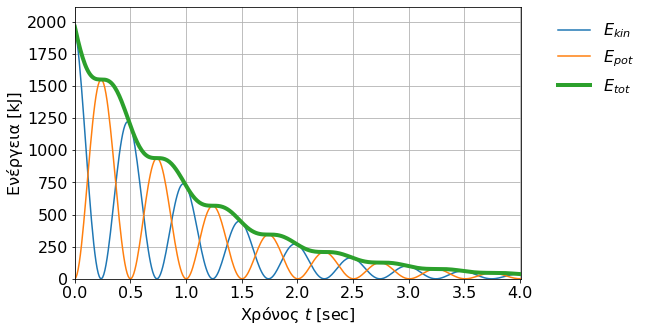

In [ ]:
#@title   
#Στο διατηρητικό αυτό σύστημα ανταγωνίζονται δύο ειδών ενέργειες.
#Η κινητική ενέργειά του, που σε κάθε χρονική στιγμή προκύπτει από τη σχέση Εκινιτική=1/2 Μάζα Ταχύτητα^2
Ekin=1/2*M_ref*v(tn)**2
#και η ελαστική δυναμική ενέργεια του ταλαντωτή
Epot=1/2*K_ref*u(tn)**2
#ενώ η ολική ενέργεια είναι
Etot=Ekin+Epot

plt.figure(figsize=(8, 5))

# Plot the data
plt.plot(tn,Ekin, label='$E_{kin}$')
plt.plot(tn,Epot, label='$E_{pot}$')
plt.plot(tn,Etot, label='$E_{tot}$',linewidth=4)

#Format the plot
plt.grid()
plt.xlabel('Χρόνος $t$ [sec]',fontsize='16')
plt.ylabel('Ενέργεια [kJ]', fontsize='16')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,loc='upper left',frameon=False,bbox_to_anchor=(1.05, 1))
plt.ylim(0,1.1*float(Etot.item(1)));
plt.xlim(0.0, 4*T);




Παρατηρείστε πώς

1. Η ολική ενέργεια $Ε_{tot}$ είναι όντως αμετάβλητη καθόλη τη διάρκεια της κίνησης (ή ακριβέστερα του χρονικού διαστήματος που παρακολουθούμε). 

2. Η κινητική και η δυναμική ενέργεια εναλλάσουν τα ακρότατά τους. Όταν η δυναμική ενέργεια έχει τη μέγιστη τιμή της, η κινητική ενέργεια είναι μηδέν και αντίστροφα. 

3. Η ελάχιστη τιμή της δυναμικής ενέργειασ είναι 0. Γιατί? Διότι αυτή εξαρτάται από την μετατόπιση $u$ την οποία και μετράμε από την αρχική απαραμόρφωτη κατάσταση. Κάθε φορά λοιπόν που το σώμα περνάει από τη θέση $Ο$, η δυναμική του ενέργεια μηδενίζεται. 

4. Τότε λοιπόν, η απομένουσα δυναμική ενέργεια θα πρέπει να είναι τέτοια ώστε να ισοδυναμεί στην αρχική ολική ενέργεια του συστήματος. Αυτό σημαίνει ότι λαμβάνει τη μέγιστη τιμή της. Θυμηθείτε ότι η κινητική ενέργεια είναι 

\begin{equation}
E_{kin}=\frac{1}{2}M\dot{u}^2
\end{equation}

5. Συμπέρασμα? Όταν το σώμα περνάει από τη θέση ισορροπίας του το κάνει με τη μέγιστη δυνατή ταχύτητα. 

Ας συνοψίσουμε

1. Στις ακραίες θέσεις $Α$ και $Α'$ το πάρε-δώσε των ενεργειών επιβάλλει πως η μετατόπιση θα είναι ίση (κατ' απόλυτη τιμή) με την αρχική και η ταχύτητα ίση με $0$. Στιγμιαία, ο ταλαντωτής στις ακραίες θέσεις *σταματάει*. 

2. Από τη θέση αρχικής ισορροπίας $Ο$ ο ταλαντωτής διέρχεται με τη μέγιστη δυνατή ταχύτητα.

#### **Ερώτηση 4**

Ωραία όλα τα παραπάνω. Γιατί όμως αφού ο ταλαντωτής φτάνει στη θέση $Α'$ με μηδενική ταχύτητα δε μένει εκεί? Η ενέργεια διατηρείται, το σώμα έχει μηδενίσει την ταχύτητά του και όλα ωραία όλα καλά. 

Ποιος **ακριβώς** είναι ο λόγος που το σώμα αυτό είναι καταδικασμένο να περιφέρεται από τη θέση $Α'$ στη θέση $Α$ και πάλι στη θέση $Α'$ και πάλι στη θέση $Α$ <a href="https://www.youtube.com/watch?v=1hPSRv0lWds"> για πάντα και για πάντα και για πάντα?</a>

Σκέψου για 5 λεπτά ποια ακριβώς είναι αυτή η αρχή που  από τη θέση $Α'$ στη θέση $Α$ δεν αφήνει κανένα περιθώριο στον ταλαντωτή παρά να συνεχίσει να κινείται στο διηνεκές. Μετά, πάτησε το μικρό τρίγωνο πάνω αριστερά για να δεις την απάντηση. 

---



Τη χρονική στιγμή $t=0$ αφήνουμε το σώμα από τη θέση $u=u_0$. Υπό τη δράση της ελαστικής αντίδρασης τη χρονική στιγμή $t=0$ 

$$F_R=Ku_0$$

το σώμα εκσφεδονίζεται προς τα δεξιά. Αρχικά η ταχύτητά του ήταν ίση με το μηδέν αλλά βαθμιαία αυξάνεται. Το σώμα επιταχύνει. 

Όσο πλησιάζει τη θέση $Ο$, η μετατόπιση $u(t)$ μειώνεται. Η ελαστική αντίδραση $F_R$ επίσης μειώνεται. 

Στη θέση $Ο$ η ελαστική αντίδραση είναι ακριβώς ίση με το μηδέν. Το σώμα όμως δε σταματάει γιατί έχει ήδη χτίσει ταχύτητα στο ταξίδι του. Περνάει από το $Ο$ με τη μέγιστη δυνατή ταχύτητα το διάνυσμα της οποίας δείχνει προς το $Α'$.

<br><br>

**ΤΕΡΑΣΤΙΑ ΠΑΡΑΤΗΡΗΣΗ** Από τη στιγμή που ο ταλαντωτής περνάει από το $Ο$ και κινείται προς το $Α'$ η φορά της ελαστικής αντίδρασης αλλάζει. Πλέον αντί να είναι κατά τη φορά της κίνησης είναι αντίθετη. Μοιραία, η ταχύτητα του σώματος αργά αλλά σταθερά μειώνεται. 

Η ταχύτητα θα μειωθεί μέχρι να μηδενιστεί. Είδαμε ότι αυτό γίνεται ακριβώς τη στιγμή που το σώμα βρίσκεται στη θέση $Α'$. 

Μα για μισό λεπτό. Τώρα το σώμα έχει φτάσει στη θέση $Α'$, έχει σταματήσει, και πάνω του ασκείται η μέγιστη δυνατή ελαστική αντίδραση για μετατόπιση $u=u_0$. Η εξίσωση δυναμικής ισοροπίας μας λέει πως αυτή η ελαστική αντίδραση ισοδυναμεί με μία δύναμη αδράνειας η οποία θα μας δώσει μια επιτάχυνση κατά τη φορά $Α' -> Α$

E τότε o ταλαντωτής δεν έχει τίποτα άλλο να κάνει παρά να εκτοξευθεί προς την κατεύθυνση του $Α$. Όταν φτάσει εκεί, η ελαστική δύναμη αντίδρασης θα τον εκτινάξει πάλι προς το $Α'$ και το ίδιο μοτίβο θα επαναληφθεί πάλι και πάλι. 

### Εφαρμογή 1.4 Η γωνιακή ιδιοσυχνότητα

Τα μαθηματικά μας έδειξαν πώς στη λύση της εξίσωσης κίνησης $(1)$ υπεισέρχεται η ποσότητα $\omega$ η οποία και ονομάζεται γωνιακή συχνότητα του συστήματος. Η γωνιακή συχνότητα δίδεται από την σχέση $(5)$ η οποία και παρατίθεται εδώ για ευκολία

\begin{equation}
\omega=\sqrt{\frac{K}{M}}
\end{equation}

και έχει μονάδες rad/sec. 

Δύο ερωτήσεις μπορούν εύλογα να προκύψουν
<br><br>
1. Γιατί αυτή η ποσότητα λέγεται **γωνιακή** ιδιοσυχνότητα?
<br><br>
2. Γιατί οι μονάδες της είναι rad/sec. Από διαστατική άποψη, τα rad δεν προκύπτουν από τον ορισμό της ποσότητας $\omega$. Όυτε η στιβαρρότητα, ούτε η μάζα έχουν rad στον ορισμό τους. 
---

Ας ξεκινήσουμε με την πρώτη ερώτηση. Η ποσότητητα $\omega$ εμφανίζεται στο τριγωνομετρικό μέρος της εξίσωσης της απόκρισης και επιδρά πάνω στον χρόνο. Όσο μεγαλύτερη είναι η τιμή της ποσότητας $\omega$ τόσο πιο **γρήγορα μεταβάλλεται** ο τριγωνομετρικός όρος. Οι λέξεις δεν τονίζονται τυχαία. 

Η ιδιοσυχνότητα $\omega$ είναι μία **ταχύτητα** ιδιαίτερη για το σύστημα που περιγράφει. Ο λόγος για τον οποίο ονομάζεται γωνιακή έχει να κάνει με το γεγονός πως καθορίζει το πόσο γρήγορα ή αργά μεταβάλλεται ο τριγωνομετρικός όρος της απόκρισης. 

Για να δείτε την επίδραση της ταχύτητας αυτής στην απόκριση του συστήματος, πειραματιστείτε με τον μοχλό στο ακόλουθο γράφημα. 

---
Στο διάγραμμα χρησιμοποιείται ως απόκριση αναφοράς, η απόκριση του συστήματος που εξετάζουμε σε αυτό το φύλλο με συχνότητα $\omega=2\pi$.

Μετακινώντας τον μοχλό αριστερά ή δεξία, μπορείτε να αυξομειώνεται τη γωνιακή ιδιοσυχνότητα του συστήματος. Οι αρχικές συνθήκες παραμένων οι ίδιες.

Η απόκριση απεικονίζεται για ένα διάστημα 4 sec.

Μπορείτε να επιβεβαιώσετε τα ακόλουθα

1. Για τιμές της γωνιακής ιδιοσυχνότητας μεγαλύτερες του $2\pi$ το σύστημα κάνει περισσότερες ταλαντώσεις στην ίδια χρονική περίοδο των 4sec.

2. Αντίστοιχα, για τιμές της γωνιακής ιδιοσυχνότητας μικρότερες του $2\pi$ το σύστημα κάνει λιγότερες ταλαντώσεις στην ίδια χρονική περίοδο των 4sec.

3. Προσέξτε πως η ταχύτητα ταλάντωσης του συστήματος μεταβάλλεται αυξάνοντας την ιδιοσυχνότητα. Γιατί?

Το διάστημα που έχει να διανύσει ο ταλαντωτής παραμένει το ίδιο. Θα πάει από το σημείο $Α$ στο $Α'$ και πίσω ξανά και ξανά. Εφόσον μεγαλύτερες τιμές της ιδιοσυχνότητας σημαίνουν περισσότερες ταλαντώσεις στο ίδιο χρονικό διάστημα, η ταχύτητα με την οποία κινείται η μάζα πρέπει να είναι μεγαλύτερη. 

Τούτο αντικατροπτίζεται και στα μαθηματικά, αφού το πλάτος της ταχύτητας ταλάντωσης είναι ανάλογα της γωνιακής συχνότητάς του. (δες σχέση $(8)$)


---











In [ ]:
#@title 
omega = widgets.FloatSlider(min=0.1, max=20, step=0.1, value=2*sp.pi, description='Γωνιακή Συχνότητα', disabled=False, continuous_update=False)
ui = widgets.HBox([omega])

out = widgets.interactive_output(OmegaTimeHistories, {'omega': omega})
display(ui, out)


Output()

Oso mikroteri i syxnotita toso pio arga aposvenitai i talantwsi

I diafora stin periodo talantwsis tis aposvenimenis kai tis allis den einai kai toso megali



---

**Πολύ σημαντική παρατήρηση** Προκύπτει λοιπόν πως η δυναμική συμπεριφορά ενός συστήματος, εξαρτάται κατά τρόπο άμεσο όχι από τη μάζα του μόνον, όχι από τη στιβαρρότητά του μόνο αλλά από το λόγο τους. 

Τούτο σημαίνει πως συστήματα τα οποία εκ πρώτης όψεως μπορεί να είναι πολύ διαφορετικά το ένα από το άλλο, π.χ., μία εύκαμπτη δεξαμενή νερού, και ένα δύσκαμπτο μονόροφο κτίριο, ενδεχόμενα να παρουσιάζουν ποιοτικά παρόμοια δυναμική συμπεριφορά αν υποβληθούν στις ίδιες αρχικές συνθήκες, υπό την προϋπόθεση πως η κατανομή της μάζας τους είναι τέτοια που να φέρνει τις ιδιοσυχνότητές τους σε ίδια ή παραπλήσια επίπεδα.

Αυτή η παρατήρηρη μας έχει επιτρέψει να κατατάσουμε τα δυναμικά συστήματα με βάση τη συχνότητά τους και να τα μελετούμε αναλόγως όπως θα δούμε στη συνέχεια.

---

Ως προς τη δεύτερη ερώτηση. Τα rad (ακτίνια) δεν είναι μονάδα μέτρησης με την αυστηρή έννοια του όρου. Στο SI το rad αναφέρεται ως *παράγωγο* μέγεθος (derivative measure). Είναι δηλαδή ένας καθαρός αριθμός. 

Για την ακρίβεια, ο ορισμός του rad είναι

"Το μέτρο σε ακτίνια κάθε επίκεντρης γωνίας $\theta$ ισούται με το λόγο του μήκους τόξου $s$ που ορίζει η γωνία προς την ακτίνα $R$ του αντίστοιχου κύκλου"

Με βάση τον ορισμό επομένως ισχύει 

\begin{equation}
\theta_{rad}=\frac{s}{R}
\end{equation}

Προκύπτει επομένως πως οι μονάδες του rad είναι μήκος/ μήκος (ή m/m) και επομένως το rad στην πραγματικότητα είναι *αδιάστατο*. 

Άρα, όταν αναφερόμαστε στις μονάδες της γωνιακής ιδιοσυχνότητας, είτε πούμε rad/sec είτε 1/sec δεν είμαστε και πολύ λάθος. Είθισται να χρησιμοποιούμε τις μονάδες rad/sec επειδή ακριβώς αναφερόμαστε στην ποσότητα $\omega$ ως **η γωνιακή ιδιοσυχνότητα** του συστήματος. 

### Εφαρμογή 1.3 Τι είναι η ιδιοπερίοδος

Είδαμε πως η ελεύθερη ταλάντωση ενός μονοβάθμιου συστήματος δεν είναι παρά η επανάληψη του ίδιου μοτίβου από το σημείο $Α'$ στο $Α$, από το $Α$ στο $Α'$ και πίσω στο διηνεκές. 

Το σύστημα, κάθε φορά επιστρέφει στη θέση από την οποία ξεκίνησε. Γι αυτό το λόγο, αναφερόμαστε στην ταλάντωση με τον όρο **κύκλος**. Η κίνηση του συστήματος προφανώς δεν είναι κυκλική, ποιοτικά όμως έχει τα ίδια ακριβώς χαρακτηριστικά.

Αρκεί λοιπόν κάποιος να γνωρίζει τι συμβαίνει κατά τη διάρκεια μίας περιφοράς γύρω από αυτόν τον νοητό κύκλο, για να γνωρίζει τι συμβαίνει σε κάθε άλλη χρονική στιγμή. Λέμε ότι η κίνηση είναι **περιοδική**.

Βασικό γνώρισμα αυτής της περιοδικής κίνησης, είναι η ο χρόνος ο οποίος απαιτείται για να διαγράψει το σύστημα έναν πλήρη κύκλο απόκρισης. Αυτή είναι η ιδιοπερίοδος του συστήματος. 

Η ιδιοπερίοδος λοιπόν είναι ο χρόνος που απαιτείται ώστε το σώμα να επιστρέψει στη θέση από την οποία ξεκίνησε. Πιο σωστά, να επιστρέψει στην **κατάσταση** στην οποία ξεκίνησε. Και **κατάσταση** στη δυναμική συμπεριφορά σημαίνει ίδια θέση και ίδια ταχύτητα. 

Στην περίπτωση του ταλαντωτή της εφαρμογής 1.1 ο οποίος ξεκινάει από τη θέση $Α'$, το διάγραμμα της απόκρισης είναι το ακόλουθο. Από το διάγραμμα και μόνο μπορεί κανείς να συμπεράνει ότι ο χρόνος που απαιτείται για έναν πλήρη κύκλο ταλάντωσης είναι $Τ=1$ sec. 

Είδαμε από τη θεωρία πως η ιδιοπερίοδος εξαρτάται μόνο από τις μηχανικές ιδιότητες του συστήματος, τη μάζα και τη στιβαρρότητα και συγκεκριμένα 

\begin{equation}
T=2\pi\sqrt{\frac{M}{K}}
\end{equation}

#### Ερώτηση 5 

Όσο μεγαλύτερη είναι η μάζα του συστήματος τόσο περισσότερο χρόνο θα χρειαστεί για να ολοκληρώσει έναν κύκλο ταλάντωσης. Είναι αυτό λογικό?


---



Ας θεωρήσουμε το σύστημα που εξετάζουμε και ας πούμε ότι η μάζα του είναι μεγαλύτερη της αρχικής. 

Η μέγιστη μετατόπιση δεν εξαρτάται από τη μάζα (είναι η μετατόπιση που αρχικά επιβάλλουμε στο σύστημα). Επομένως, η ελαστική αντίδραση που σε κάθε θέση ασκείται στο σύστημα είναι ίδια με αυτή του αρχικού συστήματος (μάζας $Μ=1$tn). 

Σε κάθε θέση, η ελαστική αντίδραση ισορροπεί με την αδρανειακή. Εφόσον η ελαστική δύναμη των δύο συστημάτων είναι η ίδια, η αδρανειακή δύναμη των δύο συστημάτων θα είναι επίσης η ίδια. 

Αφού η αδρανειακή δύναμη πρέπει να είναι η ίδια και η μάζα του συστήματος έχει αυξηθεί, αυτόματα η επιτάχυνση του συστήματος στην ίδια θέση πρέπει να είναι μικρότερη. Το σύστημα με τη μεγαλύτερη μάζα είναι **πιο αργό**.

Εφόσον το νέο σύστημα είναι πιο αργό, θα χρειαστεί περισσότερο χρόνο για να διανύσει την ίδια απόσταση (ένας κύκλος ταλάντωσης). Επομένως  η ιδιοπερίοδος θα είναι μεγαλύτερη.

Στο ακόλουθο σχήμα, μπορείτε να πειραματιστείτε μεταβάλλοντας τη μάζα του συστήματος. Η στιβαρρότητά του διατηρείται σταθερή και ίση με $Κ=4\pi^2$ kN/m. Για κάθε μάζα, παρουσιάζεται η μεταβολή της ελαστικής δύναμης ώς προς τη μετατόπιση, η μεταβολή της αδρανειακής δύναμης ως προς την μετατόπιση, η χρονοϊστορία της μετατόπισης και η χρονοϊστορία της επιτάχυνσης. 

Τα αποτελέσματα παρουσιάζεται για χρονικό διάστημα 1sec, όση δηλαδή και η ιδιοπερίοδος του συστήματος με μάζα $Μ$=1 tn.

H απόκριση του νέου συστήματος συγκρίνεται κάθε φορά με την απόκριση του αρχικού, μάζας $Μ=1$ tn.


In [ ]:
#@title 
mass = widgets.FloatSlider(min=0.5, max=20, step=0.5, value=1, description='Μάζα [tn]', disabled=False, continuous_update=False)
ui = widgets.HBox([mass])
                         
out = widgets.interactive_output(GetUFreePlots, {'M': mass, 'K': fixed(K_ref), 'C': fixed(C_ref)} )
display(ui, out)

Παρατηρείστε πως

1. Ανεξάρτητα της μάζας, η τιμή της ελαστικής αντίδρασης και της αδρανειακής δύναμης παραμένει αμετάβλητη. Σε κάθε θέση, η μία είναι ακριβώς αντίθετη της άλλης ώστε το άθροισμά τους να είναι ίσο με το μηδέν. Ισορροπία! 

2. Αυξανόμενης της μάζας η επιτάχυνση του συστήματος μειώνεται. Εφόσον η επιτάχυνση μειώνεται, το σύστημα χρειάζεται περισσότερο χρόνο για να διανύσει την απόσταση από το σημείο Α στο Α' και πίσω στο Α. 

3. Πράγματι, για μάζες μεγαλύτερες του 1tn το σύστημα δεν ολοκληρώνει τον κύκλο του στο χρονικό διάστημα του 1sec. Επομένως, η ιδιοπερίοδός του είναι μεγαλύτερη του 1sec. 

In [ ]:
#@title
widgets.interact_manual(AnimateUDF, 
        M=FloatSlider( min=1, max=20, step=1, value=1, layout=Layout(width='25%'),continuous_update=False),
        K=fixed(K_ref),
        C=fixed(C_ref));              

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='M', layout=Layout(width='25…

Αν τα παραπάνω δεν είναι ακόμα κατανοητά, δοκιμάστε την ακόλουθη εφαρμογή και παρατηρείστε πώς κινείται ο ταλαντωτής κάτω δεξιά καθώς αλλάζει η μάζα του. 

Είναι γεγονός πως όσο αυξάνει η μάζα, ο ταλαντωτής πράγματι κινείται όλο και πιο αργά. 

Ενώ για $Μ=1$ tn, μπορεί σε ένα δευτερόλεπτο να πάει από το σημείο $Α$ στο $Α'$ και πίσω, για $Μ=20$ tn, ίσα που προλαβαίνει να πάει από το σημείο $Α$ στο $Ο$.


#### Ερώτηση 6 

Εντάξει με τη μάζα. Αλλά ο ορισμός της ιδιοπεριόδου επίσης μας λέει ότι οσο μεγαλύτερη είναι η στιβαρότητα του συστήματος τόσο λιγότερο χρόνο θα χρειαστεί για να ολοκληρώσει έναν κύκλο ταλάντωσης. 

Είναι **αυτό** λογικό?


---

Με τον ίδιο συλλογισμό, μπορεί κανείς να εξηγήσει γιατί συστήματα αυξανόμενης στιβαρρότητας έχουν μικρότερη ιδιοπερίοδο. 

Στο ακόλουθο σχήμα, μπορείτε να πειραματιστείτε αυξομειώνοντας τη στιβαρότητα του συστήματος για σταθερή μάζα $Μ=$ 1 tn. 

Συγκρίνοντας κάθε φορά το νέο σύστημα με το σύστημα αναφοράς (κόκκινη γραμμή) παρατηρείστε πως

1. Αυξάνοντας τη στιβαρότητα η ελαστική αντίδραση του συστήματος αυξάνει. Ένα πιο δύσκαμπτο σύστημα θα αντιδράσει με μεγαλύτερη δύναμη για την ίδια μετατόπιση.

2. Αντίστοιχα αυξάνεται η αδρανειακή δύναμη. Γιατί? Διότι η αδρανειακή δύναμη σε αυτή την περίπτωση πρέπει να εξισορροπήσει την αυξημένη ελαστική δράση.

3. Εφόσον η αδρανειακή δύναμη έχει αυξηθεί ενώ η μάζα είναι η ίδια $Μ=1$ tn, το σύστημα θα κινηθεί με μεγαλύτερη επιτάχυνση. 

4. Η επιτάχυνση είναι η μεταβολή της ταχύητητας στη μονάδα του χρόνου. Μεγαλύτερη επιτάχυνση σημαίνει μεγαλύτερη ταχύτητα για την ίδια χρονική περίοδο. 

5. Άρα, το σύστημα θα καλύψει την απόσταση από το Α στο Α' και πίσω σε μικρότερο χρόνο. Επομένως σε χρονικό διάστημα 1 sec θα κάνει περισσότερες ταλαντώσεις!



In [ ]:
#@title 
stiff = widgets.FloatSlider(min=10, max=200, step=10, value=4*sp.pi**2, description='Κ=', disabled=False, continuous_update=False)
ui = widgets.HBox([stiff])
                         
out = widgets.interactive_output(GetUFreePlots, {'K': stiff, 'M': fixed(M_ref)} )
display(ui, out)

Output()

In [ ]:
#@title
widgets.interact_manual(AnimateUDF, 
        M=fixed(M_ref),
        K=FloatSlider( min=10, max=200, step=10, value=K_ref, layout=Layout(width='25%'),continuous_update=False)); 

interactive(children=(FloatSlider(value=39.47841760435743, continuous_update=False, description='K', layout=La…

#### Ερώτηση 7 

Τελικά γιατί η ιδιοπερίοδος έχει αυτόν τον τύπο?

(προσπάθησε να αποδείξεις τον τύπο της ιδιοπεριόδου ξεκινώντας από τη σχέση $1.1$. Μετά δες την απάντηση)

---



Εφόσον η ιδιοπερίοδος δεν εξαρτάται από τις αρχικές συνθήκες, προφανώς το επιχείρημα ισχύει σε κάθε περίπτωση. 

Είδαμε πως η μετατόπιση του μονοβάθμιου ταλαντωτή υπό αρχική μετατόπιση είναι 

\begin{equation}
u(t)=u_0\cos(\omega t)
\end{equation}

όπου 

\begin{equation}
\omega=\sqrt{\frac{K}{M}}
\end{equation}

η γωνιακή συχνότητα του συστήματος. 

Ποιοτικά, ο όρος $\omega t$ δεν είναι τίποτα άλλο από μια *γωνία* όπως αυτή μετράται πάνω στον ιδεατό *κύκλο* της ταλάντωσης. Επομένως, αφού σε χρόνο $t=T$ το σύστημα έχει διαγράψει έναν κύκλο ταλάντωσης η αντίστοιχη *γωνία* πρέπει να είναι ίση με $2\pi$.

Άρα

\begin{equation}
\omega T= 2\pi 
\end{equation}

και επομένως

\begin{equation}
T=\frac{2\pi}{\omega}=2\pi\sqrt{\frac{M}{K}}
\end{equation}

In [ ]:
#@title
widgets.interact_manual(AnimateUDF, 
        M=FloatSlider( min=1, max=20, step=1, value=1, layout=Layout(width='25%'),continuous_update=False),
        K=FloatSlider( min=10, max=200, step=10, value=K_ref, layout=Layout(width='25%'),continuous_update=False)); 

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='M', layout=Layout(width='25…

NameError: ignored

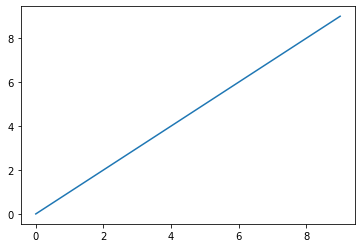

In [ ]:
import matplotlib.image as mgimg
from matplotlib.cbook import get_sample_data

im = plt.imread('ghost1.png')

fig, ax = plt.subplots()
ax.plot(range(10))

# Place the image in the upper-right corner of the figure
#--------------------------------------------------------
# We're specifying the position and size in _figure_ coordinates, so the image
# will shrink/grow as the figure is resized. Remove "zorder=-1" to place the
# image in front of the axes.
#newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=2)
newax.imshow(im)
newax.axis('off')

plt.show()

In [ ]:
import matplotlib.image as mgimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

im = plt.imread('ghost1.png')

mass = 1
K=4*sp.pi**2
omega=sp.sqrt(float(K)/mass)
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(4, 4)

ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
plt.axis('off')
line=plt.Line2D( [],[],zorder=1)
patch = plt.Circle((5, -5), 0.75, fc='r',zorder=2)

fname='ghost1.png'
img = mgimg.imread(fname)


imagebox = OffsetImage(img, zoom=1)

ab = AnnotationBbox(imagebox,  (0.4, 0.6),frameon=False, )


def init():
    line.set_data([], [])
    #ax.add_patch(patch)
    ax.add_line(line)        
    ax.add_artist(ab)
    return (patch, line, ab,)

def animate(i,omega_f):
    x, y = patch.center
    x = 5 + 3 * sp.cos(omega_f*i/100)
    y = 5 
    line.set_data([5,x],[0,y])
    #patch.center = (x, y)
    ab.xy=(x,y)    
    ab.xyann=(x,y)
    return (patch, line, ab,)
omega_test=2
anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=400, fargs=(omega_test,), 
                               interval=20,
                               blit=True)
from matplotlib import rc
rc('animation', html='html5')
plt.close()
anim                              